In [1]:
import CUDA
using Knet
using CUDA: CUDA, CuArray
using Images
using ImageMagick
using Random
using AutoGrad
using Statistics
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using IterTools: ncycle, takenth
using JLD2, FileIO

# Hyperparameters

In [2]:
bs = 64;
resolution = 32; #16 for Baseline
decoder_res = 2;
slot_size = 16;
num_slots = 4;
num_iterations = 3;
hidden_dim = 16;

mlp_hidden_dim = 32;

array_type=(CUDA.functional() ? KnetArray{Float64} : Array{Float64})

KnetArray{Float64,N} where N

# Data Loader

In [3]:
atype() = array_type
atype(x) = convert(atype(),x)

function load_image(filename)
    img = load(filename)
    img = imresize(img, (resolution,resolution))
    img = Float64.(channelview(img))
    img = img[1:3,:,:]
    img = permutedims(img, [2, 3, 1])
    img = img .* 2 .- 1
end

struct CLEVR
    images
    batchsize::Int
    num_instances::Int
    shuffle::Bool
    function CLEVR(datasetPaths; batchsize::Int=32, shuffle::Bool=false)
        nFullBatches, rem = divrem(size(datasetPaths)[end], batchsize)
        new(datasetPaths[1:nFullBatches*batchsize], batchsize, nFullBatches*batchsize, shuffle)
    end
end

function length(d::CLEVR)
    nFullBatches, rem = divrem(d.num_instances, d.batchsize)
    nFullBatches + (rem > 0)*1
end

function iterate(d::CLEVR, state=ifelse(d.shuffle, randperm(d.num_instances), collect(1:d.num_instances)))
    if length(state) > 0
        imgBatch = load_image.(d.images[state[1:(length(state) < d.batchsize ? end : d.batchsize)]])
        batch = cat(imgBatch..., dims = 4)
        state  = state[d.batchsize+1:end]
        return atype(batch), state
    end
end

iterate (generic function with 435 methods)

In [4]:
trainDataPath = "//userfiles//ashah20//datasets//tetrominoes//train//images"
files = readdir(trainDataPath);
filenames = files[endswith.(files, ".jpg")]
filenames = ["$(trainDataPath)//$(file)" for file in filenames];

clevrDataset = CLEVR(filenames, batchsize=bs, shuffle = true);

In [5]:
testDataPath = "//userfiles//ashah20//datasets//tetrominoes//val//images"
tstfiles = readdir(testDataPath);
tstfilenames = tstfiles[endswith.(tstfiles, ".jpg")]
tstfilenames = ["$(testDataPath)//$(file)" for file in tstfilenames];

clevrDatasetTest = CLEVR(tstfilenames, batchsize=bs, shuffle = false);

# Constructing the SlotAttentionModel

In [6]:
mutable struct Dense
    w
    b
    f
    p
    bias
end

function Dense(i::Int,o::Int;f=relu,pdrop=0, bias=true)
    w = param(o,i, atype = array_type)
    if(bias)
        b = param0(o, atype = array_type)
    else
        b = 0
    end
    Dense(w, b, f, pdrop, bias)
end

function (d::Dense)(x)
    if(d.bias)
        d.f.(d.w * mat(dropout(x,d.p)) .+ d.b)
    else
        d.f.(d.w * mat(dropout(x,d.p)))
    end
end

In [7]:
struct Conv; w; b; pad; f; p; end
(c::Conv)(x) = c.f.(conv4(c.w, dropout(x,c.p), padding=(c.pad,c.pad), stride=1) .+ c.b)
Conv(w1::Int,w2::Int,cx::Int,cy::Int,pad::Int, f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy, atype = array_type), param0(1,1,cy,1, atype = array_type), pad, f, pdrop)

struct DeConv; w; b; f; p; pad; end
(c::DeConv)(x) = c.f.(deconv4(c.w, dropout(x,c.p), padding=(c.pad,c.pad), stride=2) .+ c.b)[1:end-1, 1:end-1, :, :]
DeConv(w1::Int,w2::Int,cx::Int,cy::Int;f=relu,pdrop=0, pad=1) = DeConv(param(w1,w2,cy,cx, atype = array_type), param0(1,1,cy,1, atype = array_type), f, pdrop, pad)

struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)

In [8]:
function flatten(x)
    batchsize = size(x)[end]
    return array_type(permutedims(reshape(x,(size(x)[1]*size(x)[2],hidden_dim,batchsize)),(2,1,3)))
end

function printdims(x)
    println(size(x))
   return x
end

function make3d_2d(x)
   return (reshape(x,(size(x)[1],size(x)[2]*size(x)[3])))
end

function inv_make3d_2d(x, shape)
   return (reshape(x,(shape[1],shape[2],shape[3])))
end



inv_make3d_2d (generic function with 1 method)

## Layer Normalization

In [9]:
# Layer Normalization
mutable struct LayerNorm; a; b; ϵ; dim; end 

"""
    LayerNorm(dmodel)
Creates an layer normalization layer. Inputs should be hidden vectors with hidden size of dmodel
Input shape: Tensor of arbitrary number of hidden vectors [dmodel, o...]
Output shape: Identical shape of [dmodel, o...]
"""
function LayerNorm(dmodel; dim=1, eps=1e-12, atype=atype())
    a = param(dmodel; init=ones, atype=atype)
    b = param(dmodel; init=zeros, atype=atype)
    LayerNorm(a, b, eps, dim)
end


function (l::LayerNorm)(x, o...)
    μ = mean(x,dims=l.dim)
    # Albert Implementation uses corrected == false when testing
    # Source: https://github.com/huggingface/transformers/blob/b592728eff9996e2cff1c5107438c4989aaa8149/src/transformers/models/albert/modeling_albert.py#L239 
    σ = std(x,mean=μ,dims=l.dim, corrected=false)
    ϵ = eltype(x)(l.ϵ)
    l.a .* (x .- μ) ./ (σ .+ ϵ) .+ l.b # TODO: doing x .- μ twice?
end

## Slot Attention Module

In [10]:
### now the slot attention module will get this encoded features matrix####
### input dimensions of this feature matrix is channel, hxw, batchsize

mutable struct SlotAttention
    num_iterations
    num_slots
    slot_size
    project_k
    project_v
    project_q
    gru
    mu
    log_sigma
    slot_mlp
    input_norm_layer
    slot_norm_layer
    mlp_norm_layer
end


function SlotAttention(num_iterations, num_slots, slot_size, mlp_hidden_dim)
    project_k = Dense(slot_size, slot_size, bias=false)
    project_v = Dense(slot_size, slot_size, bias=false)
    project_q = Dense(slot_size, slot_size, bias=false)

    gru = RNN(slot_size, slot_size, rnnType=:gru, atype = array_type)
    
    mu = param(slot_size, 1, 1, atype=array_type)
    log_sigma = param(slot_size, 1, 1, atype=array_type)
    
    slot_mlp = Chain(Dense(slot_size, mlp_hidden_dim),
                    Dense(mlp_hidden_dim, slot_size, f=identity))
    
    input_norm_layer = LayerNorm(hidden_dim, atype=array_type)
    slot_norm_layer = LayerNorm(slot_size, atype=array_type)
    mlp_norm_layer = LayerNorm(slot_size, atype=array_type)
    
    return SlotAttention(num_iterations, num_slots, slot_size, project_k, project_q, project_v, gru, mu, log_sigma, slot_mlp, input_norm_layer, slot_norm_layer, mlp_norm_layer)
end


attn_norm_factor = slot_size ^ -0.5
epsilon=1e-8


function (s::SlotAttention)(x)
    batchsize = size(x)[end]
#     println(size(x))
    encoded = permutedims(reshape(x,(size(x)[1]*size(x)[2],hidden_dim,batchsize)),(2,1,3))
    encoded = s.input_norm_layer(encoded)
    
    flattened_enc = make3d_2d(encoded)
#     println(size(flattened_enc))

    k = s.project_k(flattened_enc)
    k = inv_make3d_2d(k, size(encoded)) #shape = [slot_size, hxw, bs]

    v = s.project_v(flattened_enc)
    v = inv_make3d_2d(v, size(encoded)) #shape = [slot_size, hxw, bs]
    
    slots = s.mu .+ exp.(s.log_sigma) .* array_type(randn(s.slot_size, s.num_slots, batchsize))


    for i in 1:s.num_iterations
        prev_slots = slots
        prev_slots = make3d_2d(prev_slots)
        s.gru.h = prev_slots
        
        slots = s.slot_norm_layer(slots)
        slots = make3d_2d(slots)
        
        q = s.project_q(slots)
        q = inv_make3d_2d(q, (s.slot_size, s.num_slots, batchsize)) #shape = [slot_size, num_slots, bs]

        # batch matrix multiplication
        attn_logits = bmm(permutedims(q,(2, 1, 3)),(attn_norm_factor .* k))
        # softmax function
#         attn = exp.(attn_logits) ./ sum(exp.(attn_logits), dims=1) 
        attn = softmax(attn_logits, dims=1)

#         attn = attn .+ epsilon
        attn = attn ./ (sum(attn, dims=2) .+ epsilon)#shape = [num_slots, hxw, bs]

        updates = bmm(v, permutedims(attn,(2, 1, 3))) #shape = [slot_size, num_slots, bs]
        updates = make3d_2d(updates)
        
        slots = s.gru(updates) #shape = [slot_size, num_slots*bs]
#         slots = prev_slots
        slots = s.slot_mlp(s.mlp_norm_layer(slots))
        slots = inv_make3d_2d(slots, (s.slot_size, s.num_slots, batchsize)) #shape = [slot_size, num_slots, bs]

    end
    
    return slots

end


In [11]:
function decoder_in_reshape(x)
    batchsize = size(x)[end]
    a = reshape(x, (1,1,slot_size, num_slots*batchsize))
    b = array_type(ones(decoder_res, decoder_res, slot_size, batchsize*num_slots))
    z = b .* a
   return z
end

function postprocess(decoder_out)
    decoder_out = reshape(decoder_out, (resolution, resolution, 4, num_slots, bs))

    recons = decoder_out[:,:,1:3,:,:]
    masks = decoder_out[:,:,4:4,:,:]
    masks = softmax(masks, dims=4)

    final_recons = reshape(sum(recons .* masks, dims=4), (resolution, resolution, 3, bs))
    return final_recons, recons, masks
end

postprocess (generic function with 1 method)

## Positional Embedding

In [12]:
add_dim(x::Array) = reshape(x, (size(x)...,1))

function build_grid(resolution)
    linspace1 = LinRange(0.0, 1.0, resolution[1])
    linspace2 = LinRange(0.0, 1.0, resolution[2])
    grid1 = (linspace1' .* ones(resolution[2]))'
    grid2 = (ones(resolution[1])' .* linspace2)'
    grid = cat(grid1,grid2; dims=3)
    grid = permutedims(grid, [3, 1, 2])
    grid = add_dim(grid)
    grid = cat(grid, 1 .- grid; dims=1)
    return grid
end


mutable struct SoftPositionEmbed
    dense
    grid
end

function SoftPositionEmbed(hidden_size::Int, resolution)
    dense  = Dense(4, hidden_size)
    grid = array_type(build_grid(resolution))
    return SoftPositionEmbed(dense, grid)
end

function (s::SoftPositionEmbed)(x)
    orig_grid_shape = size(s.grid)
    s.grid = reshape(s.grid,(size(s.grid)[1],size(s.grid)[2]*size(s.grid)[3]*size(s.grid)[4]))
    emb_proj = s.dense(s.grid)
    s.grid = reshape(s.grid,orig_grid_shape)
    emb_proj = reshape(emb_proj,(size(emb_proj)[1],orig_grid_shape[2],orig_grid_shape[3],orig_grid_shape[4]))
    emb_proj = permutedims(emb_proj, [2, 3, 1, 4])
    return x .+ emb_proj
end

## Model Initialization

In [13]:
Random.seed!(1234);

encoder = Chain(Conv(5,5,3,hidden_dim,2),
                Conv(5,5,hidden_dim,hidden_dim,2),
                Conv(5,5,hidden_dim,hidden_dim,2),
                Conv(5,5,hidden_dim,hidden_dim,2),
                Conv(1,1,hidden_dim,hidden_dim,0),
                Conv(1,1,hidden_dim,slot_size,0))

res = (resolution, resolution)
hidden_size = slot_size
encoder_pos_embed = SoftPositionEmbed(hidden_size, res)

decoder =  Chain(DeConv(5,5,slot_size,hidden_dim, pad=1),
                DeConv(5,5,hidden_dim,hidden_dim, pad=1),
                DeConv(5,5,hidden_dim,hidden_dim, pad=1),
                DeConv(5,5,hidden_dim,4, f=identity))

dec_res = (decoder_res, decoder_res)
decoder_pos_embed = SoftPositionEmbed(hidden_size, dec_res)

SlotAttentionModel = Chain(encoder,
                        encoder_pos_embed,
                        SlotAttention(num_iterations, num_slots, slot_size, mlp_hidden_dim),
                        decoder_in_reshape,
                        decoder_pos_embed,
                        decoder,
                        postprocess);

In [14]:
params(SlotAttentionModel)

40-element Array{Param,1}:
 P(KnetArray{Float64,4}(5,5,3,16))
 P(KnetArray{Float64,4}(1,1,16,1))
 P(KnetArray{Float64,4}(5,5,16,16))
 P(KnetArray{Float64,4}(1,1,16,1))
 P(KnetArray{Float64,4}(5,5,16,16))
 P(KnetArray{Float64,4}(1,1,16,1))
 P(KnetArray{Float64,4}(5,5,16,16))
 P(KnetArray{Float64,4}(1,1,16,1))
 P(KnetArray{Float64,4}(1,1,16,16))
 P(KnetArray{Float64,4}(1,1,16,1))
 P(KnetArray{Float64,4}(1,1,16,16))
 P(KnetArray{Float64,4}(1,1,16,1))
 P(KnetArray{Float64,2}(16,4))
 ⋮
 P(KnetArray{Float64,1}(16))
 P(KnetArray{Float64,1}(16))
 P(KnetArray{Float64,2}(16,4))
 P(KnetArray{Float64,1}(16))
 P(KnetArray{Float64,4}(5,5,16,16))
 P(KnetArray{Float64,4}(1,1,16,1))
 P(KnetArray{Float64,4}(5,5,16,16))
 P(KnetArray{Float64,4}(1,1,16,1))
 P(KnetArray{Float64,4}(5,5,16,16))
 P(KnetArray{Float64,4}(1,1,16,1))
 P(KnetArray{Float64,4}(5,5,4,16))
 P(KnetArray{Float64,4}(1,1,4,1))

# Checking Forward Pass

In [15]:
function mse(predictions, targets)
    N = length(targets)
    y = 1/(2*N) * sum((predictions .- targets).^2)
    return y
end

mse (generic function with 1 method)

In [16]:
x = first(clevrDataset)
x = array_type(x)

final_recons, recons, masks = SlotAttentionModel(x);
error = mse(final_recons, x)

0.40459616859726066

In [17]:
function loss(model, input_batch)
    final_recons, recons, masks = model(input_batch)
    loss = mse(final_recons, input_batch)
    return loss
end

loss (generic function with 1 method)

In [18]:
macro gcheck1(ex); esc(:(@gcheck $ex (delta=0.000001, nsample=2, rtol=0.05, atol=0.001, verbose=1))); end
Random.seed!(123);
sample = first(clevrDataset);

In [19]:
checklayer = Conv(5,5,3,16,2)

function checkloss(model, input_batch)
    recon = model(input_batch)
    loss = mean(recon)
    return loss
end

checkloss (generic function with 1 method)

In [20]:
L = @diff loss(SlotAttentionModel, sample)
p = params(SlotAttentionModel)[1]
g = grad(L, p)
println(g)

K64(5,5,3,16)[-3.412738641879724e-5⋯]


# Training

In [21]:
val_loss = 0
for testbatch in clevrDatasetTest
    val_loss += loss(SlotAttentionModel, testbatch)
end
val_loss = val_loss ./ length(clevrDatasetTest)
println(val_loss)

0.4040647552414992


In [22]:
#training hyperparameters
num_epochs = 100
base_learning_rate = 0.0004
warmup_steps = 10000
decay_rate = 0.5
decay_steps = 100000

# temporary variables
current_step = 0
val_losses = zeros(num_epochs)

for epoch in 1:num_epochs
    val_loss = 0
    for batch in clevrDataset
        if current_step < warmup_steps
            learning_rate = base_learning_rate*(current_step/warmup_steps)
        else
            learning_rate = base_learning_rate*(decay_rate^(current_step/decay_steps))
        end
        progress(adam!(loss, [(SlotAttentionModel, batch)], params=params(SlotAttentionModel), lr = learning_rate))
    end
    if (epoch % 1 == 0)
        println(epoch)
        for testbatch in clevrDatasetTest
            val_loss += loss(SlotAttentionModel, testbatch)
        end
        val_loss = val_loss ./ length(clevrDatasetTest)
        println(val_loss)
    end
end

1
0.06206435885905698
2
0.057840529646221085
3
0.054845653781127955
4
0.05233507539267131
5
0.04736997776101158
6
0.045654053380707944
7
0.04470318910159077
8
0.04276593496954696
9
0.03825942253172854
10
0.03689374132344736
11
0.03577043269637324
12
0.03501562291653444
13
0.034764109904123416
14
0.03378593553802776
15
0.03329086438178248
16
0.03243697592059571
17
0.030636246023750473
18
0.02676136029349658
19
0.024971756148873026
20
0.024023951519053833
21
0.023452556826001454
22
0.02281982449817701
23
0.02247383796105602
24
0.021714235359372783
25
0.02131156332450849
26
0.0212670229271639
27
0.020989421604533605
28
0.020583457242992383
29
0.020180553671891276
30
0.020105439952054875
31
0.02007582489048087
32
0.019432628840667647
33
0.018961698911418697
34
0.019135241782133126
35
0.019011181865214336
36
0.018454887046832475
37
0.01814825156481238
38
0.018908549868470036
39
0.018065995850064465
40
0.01781307473578346
41
0.017645724264879058
42
0.01754783592548948
43
0.017579252961359267

In [23]:
@save "slotattention_tetrominoes.jld2" SlotAttentionModel

# Sampling

In [24]:
@load "slotattention_tetrominoes.jld2"

1-element Array{Symbol,1}:
 :SlotAttentionModel

In [25]:
sample_number = 10

using PyPlot
samplesDataPath = "//userfiles//ashah20//datasets//tetrominoes//val//images"
smpfiles = readdir(samplesDataPath);
smpfilenames = smpfiles[endswith.(smpfiles, ".jpg")]
smpfilenames = ["$(samplesDataPath)//$(file)" for file in smpfilenames];

clevrDatasetSamples = CLEVR(smpfilenames, batchsize=64, shuffle = true);
input_samples = first(clevrDatasetSamples);

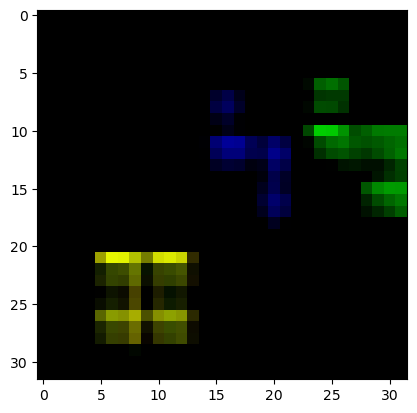

PyObject <matplotlib.image.AxesImage object at 0x2adbbdc99fa0>

In [26]:
in_sample = input_samples
in_sample = in_sample .* (in_sample.>0)
in_sample = in_sample .* (in_sample.<1)
in_sample = Array{Float32}(in_sample);
imshow(in_sample[:,:,:,sample_number])

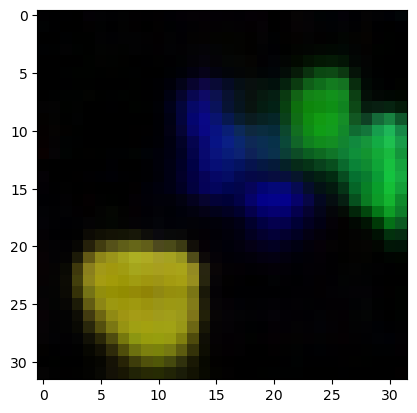

PyObject <matplotlib.image.AxesImage object at 0x2adbbdd8c2e0>

In [27]:
out_samples, slots_samples, masks_samples = SlotAttentionModel(input_samples)
out_samples = out_samples .* 0.5 .+ 0.5
out_samples = out_samples .* (out_samples.>0)
out_samples = out_samples .* (out_samples.<1)
out_samples = Array{Float32}(out_samples);
imshow(out_samples[:,:,:,sample_number])